# BlogCatalog exploration

In [1]:
# %load ../../projects/scale/blogcatalog.py
import csv
from collections import defaultdict
import os
import pickle

import numpy as np
import networkx as nx

import keras
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from nw2vec import layers
from nw2vec import ae
from nw2vec import utils
from nw2vec import batching
import settings

In [2]:
# ### PARAMETERS ###

# Data
crop = 200

# Model
n_ξ_samples = 1
dim_l1, dim_ξ = 10, 10
use_bias = False

# Training
loss_weights = [1.0, 1.0, 1.0]  # q, p_adj, p_v
n_epochs = 10000
# seeds_per_batch = len(nodes) -> defined below
max_walk_length = 1
p = 1
q = 1
neighbour_samples = 30

In [3]:
# ### MISC. SETUP VARIABLES ###

#if 'CUDA_VISIBLE_DEVICES' not in os.environ:
#    raise ValueError('CUDA_VISIBLE_DEVICES not set')
#MODEL_NAME = os.path.split(__file__)[-1][:-3]
#MODEL_PATH = os.path.join(settings.SCALE_PATH, MODEL_NAME)
#if not os.path.exists(MODEL_PATH):
#    os.mkdir(MODEL_PATH)

In [4]:
cd /home/slerique/Code/nw2vec

In [5]:
# ### LOAD DATA ###

# ## Get the full list of nodes and groups ##

# nodes
nodes = []
with open('datasets/BlogCatalog-dataset/data/nodes.csv') as csvfile:
    reader = csv.reader(csvfile)
    nodes = [int(row[0]) for row in reader]
if crop is not None:
    nodes = nodes[:crop]
assert len(nodes) == len(set(nodes))
nodes = set(nodes)

# groups
groups = []
with open('datasets/BlogCatalog-dataset/data/groups.csv') as csvfile:
    reader = csv.reader(csvfile)
    groups = [int(row[0]) for row in reader]
assert len(groups) == len(set(groups))
groups = set(groups)


# ## Generate graph from edges and node data ##

# Read edges.csv and make a network out of it
edges = defaultdict(list)
with open('datasets/BlogCatalog-dataset/data/edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes and int(row[1]) in nodes:
                edges[int(row[0])].append(int(row[1]))
        else:
            edges[int(row[0])].append(int(row[1]))

g = nx.from_dict_of_lists(edges, create_using=nx.Graph())
if crop is not None:
    g.add_nodes_from(nodes)

# Read group-edges.csv and add that info to each node
group_edges = defaultdict(list)
with open('datasets/BlogCatalog-dataset/data/group-edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes:
                group_edges[int(row[0])].append(int(row[1]))
        else:
            group_edges[int(row[0])].append(int(row[1]))

for node, data in g.nodes.items():
    data['groups'] = group_edges[node]

In [6]:
# ## Sanity checks ##

assert set(g.nodes) == nodes
if crop is None:
    assert set().union(*[groups for _, groups in g.nodes(data='groups')]) == \
        groups

In [7]:
# ## Update model parameters ##
seeds_per_batch = len(nodes)
dim_data = len(groups)
dims = (dim_data, dim_l1, dim_ξ)
#DATA_PARAMETERS = 'crop={crop}'.format(crop=crop)
#VAE_PARAMETERS = (
#    'adj_cross_entropy_weighing=False'
#    '-feature_decoder=Bernoulli'
#    '-n_ξ_samples={n_ξ_samples}'
#    '-dims={dims}'
#    '-bias={use_bias}').format(n_ξ_samples=n_ξ_samples,
#                               dims=dims, use_bias=use_bias)
#TRAINING_PARAMETERS = (
#    'loss_weights={loss_weights}'
#    '-seeds_per_batch={seeds_per_batch}'
#    '-WL={max_walk_length}'
#    '-p={p}'
#    '-q={q}'
#    '-neighbour_samples={neighbour_samples}'
#    '-n_epochs={n_epochs}').format(loss_weights=loss_weights,
#                                   seeds_per_batch=seeds_per_batch,
#                                   max_walk_length=max_walk_length,
#                                   p=p, q=q,
#                                   neighbour_samples=neighbour_samples,
#                                   n_epochs=n_epochs)
#MODEL_DATA = os.path.join(MODEL_PATH,
#                          DATA_PARAMETERS + '---' +
#                          VAE_PARAMETERS + '---' +
#                          TRAINING_PARAMETERS)

In [8]:
# ### DEFINE TRAINING LABELS ###

labels = np.zeros((len(nodes), len(groups)))
nodes_offset = min(nodes)
groups_offset = min(groups)
for n, data in g.nodes.items():
    labels[n - nodes_offset, np.array(data['groups']) - groups_offset] = 1
# labels += np.random.normal(scale=.2, size=labels.shape)

features = utils.scale_center(labels)

In [9]:
# ### BUILD THE VAE ###

n_nodes = len(nodes)

# Real adjacency from BlogCatalog
nx_node_ordering = np.array(sorted([[n - 1, i] for i, n in enumerate(g.nodes)]))[:, 1]
adj = nx.adjacency_matrix(g).astype(np.float32)[nx_node_ordering, :][:, nx_node_ordering]

# Random adjacency
#import scipy
#adj = np.random.binomial(1, .07 * np.ones((n_nodes, n_nodes)))
#adj[np.arange(n_nodes), np.arange(n_nodes)] = 0
#adj = np.triu(adj) + np.triu(adj).T
#adj = scipy.sparse.csr_matrix(adj)

def build_q(dims, use_bias=False):
    dim_data, dim_l1, dim_ξ = dims

    q_input = keras.layers.Input(shape=(dim_data,), name='q_input')
    # CANDO: change activation
    q_layer1_placeholders, q_layer1 = ae.gc_layer_with_placeholders(
        dim_l1, 'q_layer1', {'use_bias': use_bias, 'activation': 'relu'}, q_input)
    q_μ_flat_placeholders, q_μ_flat = ae.gc_layer_with_placeholders(
        dim_ξ, 'q_mu_flat', {'use_bias': use_bias, 'gather_mask': True}, q_layer1)
    q_logD_flat_placeholders, q_logD_flat = ae.gc_layer_with_placeholders(
        dim_ξ, 'q_logD_flat', {'use_bias': use_bias, 'gather_mask': True}, q_layer1)
    q_μlogD_flat = keras.layers.Concatenate(name='q_mulogD_flat')(
        [q_μ_flat, q_logD_flat])
    q_model = ae.Model(inputs=([q_input]
                               + q_layer1_placeholders
                               + q_μ_flat_placeholders
                               + q_logD_flat_placeholders),
                       outputs=q_μlogD_flat)

    return q_model, ('SimpleGaussian',)

q_model, q_codecs = build_q(dims, use_bias=use_bias)

def p_builder(p_input):
    # CANDO: change activation
    p_layer1 = keras.layers.Dense(dim_l1, use_bias=use_bias, activation='relu',
                                  kernel_regularizer='l2', bias_regularizer='l2',
                                  name='p_layer1')(p_input)
    p_adj = layers.Bilinear(0, use_bias=use_bias,
                            kernel_regularizer='l2', bias_regularizer='l2',
                            name='p_adj')([p_layer1, p_layer1])
    p_v = keras.layers.Dense(dim_data, use_bias=use_bias,
                             kernel_regularizer='l2', bias_regularizer='l2',
                             name='p_v')(p_layer1)
    return ([p_adj, p_v], ('SigmoidBernoulliAdjacency', 'SigmoidBernoulli'))

vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs),
    p_builder,
    n_ξ_samples,
    loss_weights
)

In [10]:
# ### DEFINE TRAINING OBJECTIVES ###

def target_func(batch_adj, required_nodes, final_nodes):
    #assert (np.where(batch_adj.toarray()[5])[0] == [9]).all()#, 35, 173, 175]).all()
    return [
        np.zeros(1),  # ignored
        utils.expand_dims_tile(
            utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]),
                                   0, n_ξ_samples),
            0, 1
        ),
        utils.expand_dims_tile(labels[final_nodes], 1, n_ξ_samples),
    ]

### Interlude: predictions before training

In [11]:
import matplotlib.pyplot as plt
import scipy.special

In [12]:
x, _, feeds = next(batching.batches(vae, adj, labels, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))

q_preds, adj_preds, v_preds = zip(*[vae.predict_on_fed_batch(x, feeds=feeds) for _ in range(10)])

adj_preds = np.array(adj_preds)
v_preds = np.array(v_preds)

adj_pred = scipy.special.expit(adj_preds[:, 0, :, :, :]).mean(1).mean(0)
v_pred = scipy.special.expit(v_preds[:, :, :, :]).mean(2).mean(0)

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

n_features_plot = 200

im1 = ax1.imshow(labels[:n_features_plot])
ax1.set_title('Real labels')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(v_pred[:n_features_plot, :])
#im2.set_norm(im1.norm)
ax2.set_title('Predicted labels')
plt.colorbar(im2, ax=ax2);

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 18, 2 * 8))

im1 = ax1.imshow(adj.toarray()[:n_features_plot, :][:, :n_features_plot])
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(adj_pred[:n_features_plot, :][:, :n_features_plot])
#im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

### Resume training

In [ ]:
# ### TRAIN ###

steps_per_epoch = int(np.ceil(len(labels) / seeds_per_batch))
history = vae.fit_generator_feed(
    batching.batches(vae, adj, labels, target_func,
                     seeds_per_batch, max_walk_length,
                     p=p, q=q, neighbour_samples=neighbour_samples),
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    check_array_lengths=False,
    shuffle=False,
    verbose=0,
    callbacks=[
        keras.callbacks.TensorBoard(),
        #ae.ModelBatchCheckpoint(MODEL_DATA + '.batch-checkpoint.epoch={epoch:05d}-batch={batch:05d}-loss={loss:.2f}.h5',
        #                        monitor='loss', period=50,
        #                        #save_best_only=True
        #                        ),
        #keras.callbacks.ModelCheckpoint(MODEL_DATA + '.epoch-checkpoint.h5',
        #                                monitor='loss',# period=1,
        #                                save_best_only=True
        #                                ),
        #TQDMCallback(),
    ]
)

## Results

In [16]:
history = {'history': history.history}

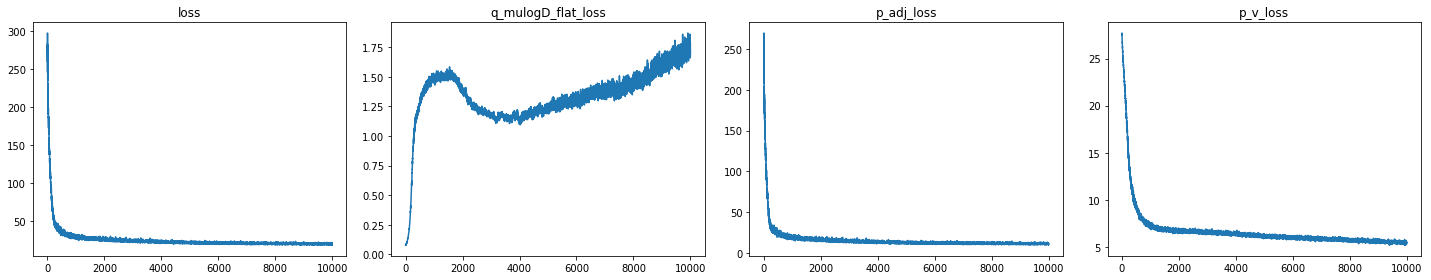

In [17]:
fig, axes = plt.subplots(1, len(history['history']), figsize=(len(history['history']) * 5, 4))
for i, (title, values) in enumerate(history['history'].items()):
    axes[i].plot(values)
    axes[i].set_title(title)
#axes[-1].set_ylim(-2000, 50)
fig.tight_layout()

In [18]:
x, _, feeds = next(batching.batches(vae, adj, labels, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))

q_preds, adj_preds, v_preds = zip(*[vae.predict_on_fed_batch(x, feeds=feeds) for _ in range(10)])

q_preds = np.array(q_preds)
adj_preds = np.array(adj_preds)
v_preds = np.array(v_preds)

q_pred = q_preds.mean(0)
adj_pred = scipy.special.expit(adj_preds[:, 0, :, :, :]).mean(1).mean(0)
v_pred = scipy.special.expit(v_preds[:, :, :, :]).mean(2).mean(0)

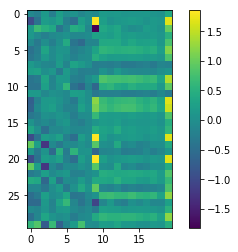

In [19]:
im = plt.imshow(q_pred[:30])
plt.colorbar(im)

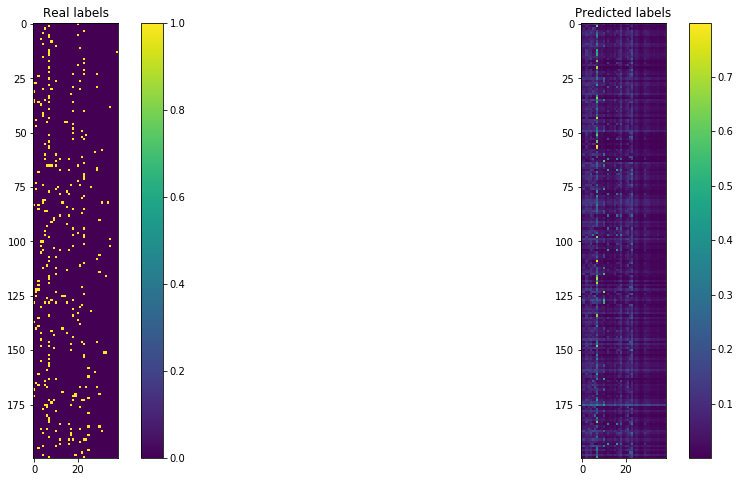

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

n_features_plot = 200

im1 = ax1.imshow(labels[:n_features_plot])
ax1.set_title('Real labels')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(v_pred[:n_features_plot, :])
#im2.set_norm(im1.norm)
ax2.set_title('Predicted labels')
plt.colorbar(im2, ax=ax2);

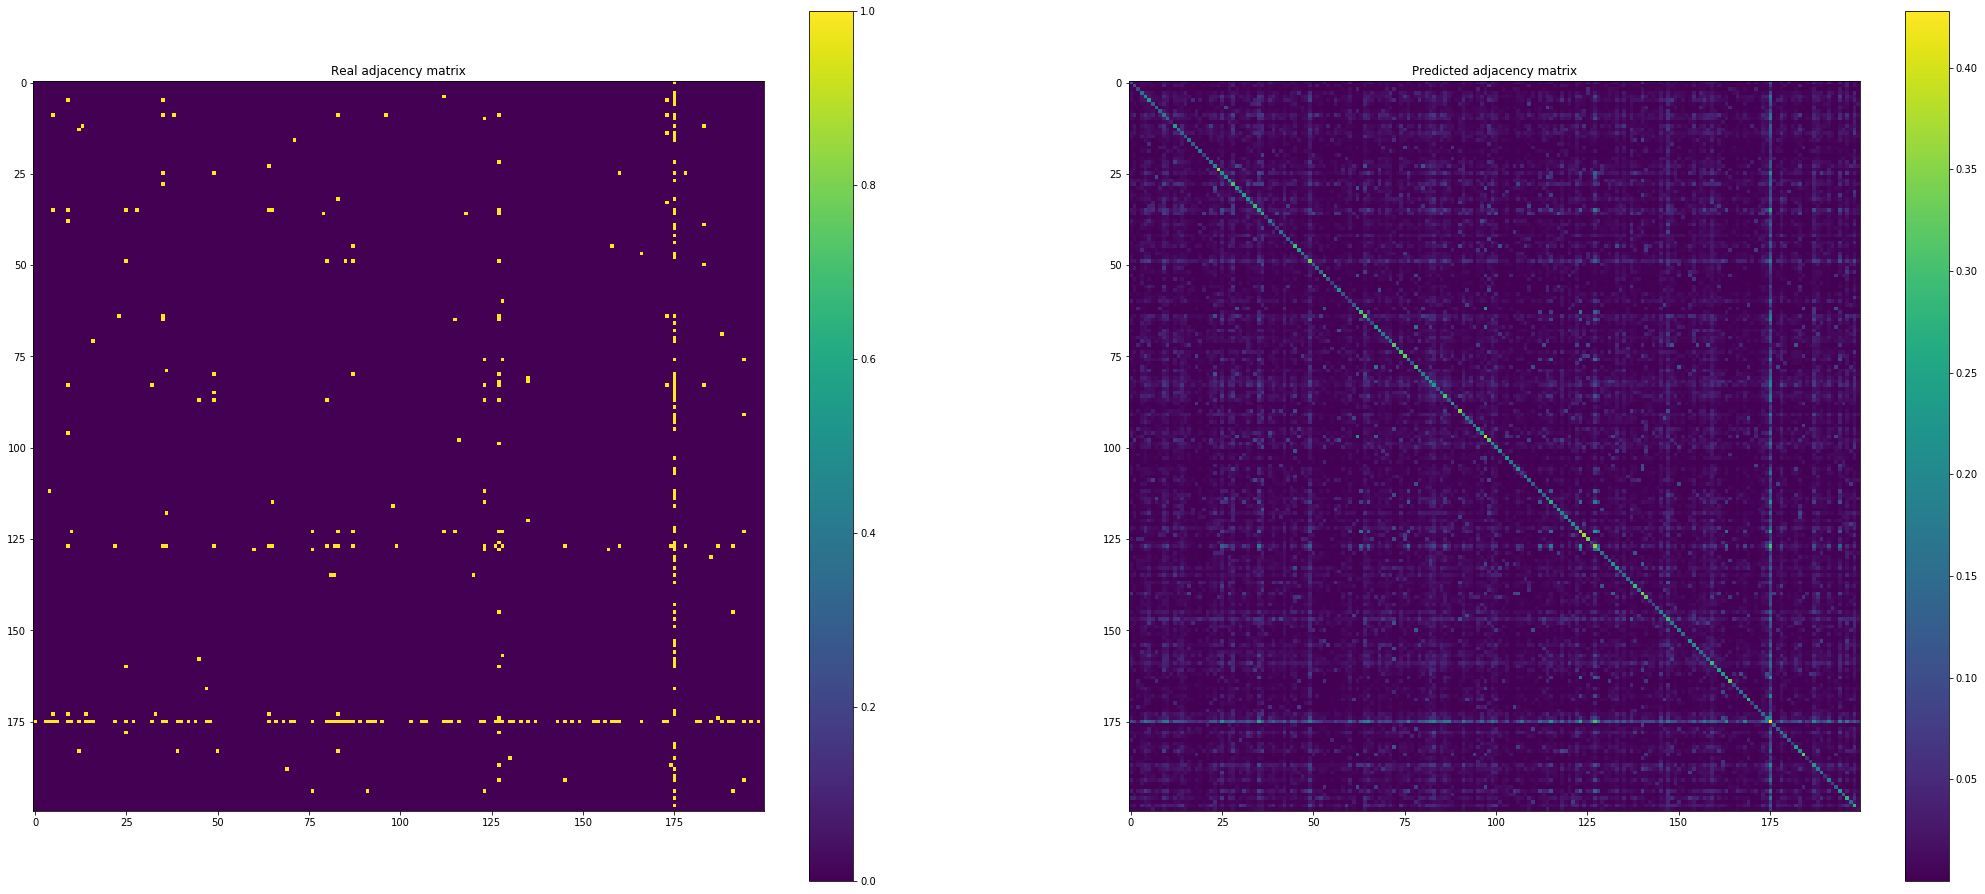

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 18, 2 * 8))

im1 = ax1.imshow(adj.toarray()[:n_features_plot, :][:, :n_features_plot])
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(adj_pred[:n_features_plot, :][:, :n_features_plot])
#im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

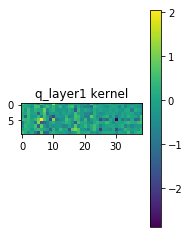

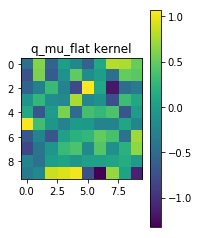

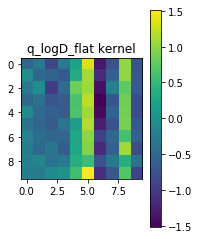

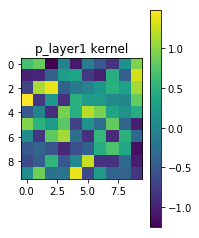

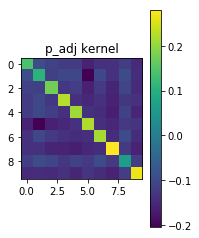

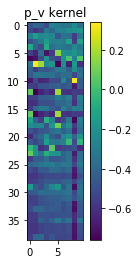

In [22]:
from keras import backend as K

for layer in vae.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)
    else:
        ax2.set_visible(False)